
## Tiny Course Load Risk — Model Dev Notebook

This notebook does:
* Load OULAD CSVs (from `backend/data/raw/`).
* Build a **term-level** training table with simple, explainable features.
* Train a **Logistic Regression** baseline.
* Evaluate precision/recall, draw a PR curve, and pick a threshold.
* Save model artifacts to `backend/model_store/baseline_v1/` and an evaluation CSV to `evals/`.


In [3]:

# If you're in your repo root, set these so the paths resolve.
# You can also run this notebook from backend/ by adjusting ROOT accordingly.

from pathlib import Path

import json, datetime as dt, joblib
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, average_precision_score, f1_score
from sklearn.metrics import PrecisionRecallDisplay, average_precision_score

from pathlib import Path



In [17]:
from pathlib import Path

DATA_RAW       = Path("../data/raw")
DATA_PROCESSED = Path("../data/processed")
MODEL_DIR      = Path("../model_store/baseline_v1")
EVALS_DIR      = Path("../../evals")

for p in (DATA_PROCESSED, MODEL_DIR, EVALS_DIR):
    p.mkdir(parents=True, exist_ok=True)

print("DATA_RAW    :", DATA_RAW)
print("MODEL_DIR   :", MODEL_DIR)
print("EVALS_DIR   :", EVALS_DIR)

DATA_RAW    : ../data/raw
MODEL_DIR   : ../model_store/baseline_v1
EVALS_DIR   : ../../evals


## Load OULAD CSVs & quick Exploratory Data Analysis

In [18]:
courses = pd.read_csv(DATA_RAW/'courses.csv')                 # code_module, code_presentation, etc.
studentInfo = pd.read_csv(DATA_RAW/'studentInfo.csv')         # id_student, studied_credits, final_result, ...

print(courses.head(3))
print(studentInfo.head(3))
print(studentInfo['final_result'].value_counts(dropna=False))

# Join minimal course metadata we need
df = studentInfo.merge(courses, on=['code_module','code_presentation'], how='left')
df.head(3)



  code_module code_presentation  module_presentation_length
0         AAA             2013J                         268
1         AAA             2014J                         269
2         BBB             2013J                         268
  code_module code_presentation  id_student gender                region  \
0         AAA             2013J       11391      M   East Anglian Region   
1         AAA             2013J       28400      F              Scotland   
2         AAA             2013J       30268      F  North Western Region   

       highest_education imd_band age_band  num_of_prev_attempts  \
0       HE Qualification  90-100%     55<=                     0   
1       HE Qualification   20-30%    35-55                     0   
2  A Level or Equivalent   30-40%    35-55                     0   

   studied_credits disability final_result  
0              240          N         Pass  
1               60          N         Pass  
2               60          Y    Withdrawn  
fi

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,module_presentation_length
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,268
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,268
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,268


## Define mapping, features, and label engineering

In [19]:
df['term_key'] = df['code_presentation'].astype(str)

first_letter = df['code_module'].astype('string').str[0].str.upper()
letter_to_level = {'A':100, 'B':200, 'C':300, 'D':400}
df['level_num'] = first_letter.map(letter_to_level).astype('float')  

df['is_stem'] = df['code_module'].astype('string').str.lower()\
               .str.contains('math|stat|comput|physics|chem|eng|tech', regex=True, na=False)

course_counts = (
    df.groupby(['id_student','term_key'], as_index=False)
      .agg(n_courses=('code_module','count'))
)

term_duration = (
    df.groupby(['id_student','term_key'], as_index=False)
      .agg(term_length_days=('module_presentation_length','max'))  
)

avg_level = ('level_num', lambda s: (s/100.0).mean())

feats = (
    df.groupby(['id_student','term_key'], as_index=False)
      .agg(
        total_credits      = ('studied_credits','sum'),
        upper_level_count  = ('level_num',      lambda s: (s >= 300).sum()),
        avg_level          = ('level_num',      lambda s: (s/100.0).mean()),
        stem_course_count  = ('is_stem',        'sum'),
      )
)

feats = (feats
         .merge(course_counts, on=['id_student','term_key'], how='left')
         .merge(term_duration, on=['id_student','term_key'], how='left'))


feats['ou_course_equiv'] = feats['total_credits'] // 15.0

label = (
    df.assign(over=df['final_result'].isin(['Fail','Withdrawn']))
      .groupby(['id_student','term_key'], as_index=False)['over']
      .max()
      .rename(columns={'over':'overload_risk'})
      .astype({'overload_risk':'int64'})
)

pts_map = {'distinction':4.0, 'pass':3.0, 'fail':1.0, 'withdrawn':0.0}
df['outcome_pts'] = df['final_result'].astype('string').str.lower().map(pts_map)

term_out = (df.groupby(['id_student','term_key'], as_index=False)
              .agg(term_gpa=('outcome_pts','mean'),
                   term_fails=('final_result', lambda s:(s.isin(['Fail','Withdrawn'])).sum()))
            .sort_values(['id_student','term_key']))
term_out['gpa_last_term']   = term_out.groupby('id_student')['term_gpa'].shift(1)
term_out['past_fail_count'] = term_out.groupby('id_student')['term_fails'].cumsum().shift(1)

training_table = (feats.merge(label, on=['id_student','term_key'])
                        .merge(term_out[['id_student','term_key','gpa_last_term','past_fail_count']],
                               on=['id_student','term_key'], how='left'))


training_table['ou_course_equiv'] = pd.to_numeric(training_table['total_credits'], errors='coerce') / 30.0

training_path = DATA_PROCESSED/'training_table.csv'
training_table.to_csv(training_path, index=False)
print("Saved:", training_path, "rows=", len(training_table))
training_table.head()


Saved: ../data/processed/training_table.csv rows= 31512


,id_student,term_key,total_credits,upper_level_count,avg_level,stem_course_count,n_courses,term_length_days,ou_course_equiv,overload_risk,gpa_last_term,past_fail_count
0,3733,2013J,60,1,4.0,0,1,261,2.0,1,NaN,NaN
1,6516,2014J,60,0,1.0,0,1,269,2.0,0,NaN,1.0
2,8462,2013J,90,1,4.0,0,1,261,3.0,1,NaN,0.0
3,8462,2014J,60,1,4.0,0,1,262,2.0,1,0.0,1.0
4,11391,2013J,240,0,1.0,0,1,268,8.0,0,NaN,2.0


## Data Preprocessing

In [20]:
from sklearn.pipeline import make_pipeline

TARGET = 'overload_risk'
FEATURES = [
    'n_courses',
    'total_credits',
    'upper_level_count',
    'avg_level',
    'stem_course_count',
    'gpa_last_term',
    'past_fail_count',
    'ou_course_equiv'
]



X = training_table[FEATURES]
y = training_table[TARGET].astype('int32')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

numeric_features = FEATURES
numeric_transformer = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
    ],
    remainder='drop', 
    verbose_feature_names_out=False 
)

X_train.head()


,n_courses,total_credits,upper_level_count,avg_level,stem_course_count,gpa_last_term,past_fail_count,ou_course_equiv
14811,1,300,0,NaN,0,NaN,0.0,10.0
10235,1,90,1,3.0,0,NaN,0.0,3.0
31368,1,30,0,NaN,0,NaN,1.0,1.0
6092,1,60,1,3.0,0,NaN,0.0,2.0
29455,1,60,1,4.0,0,NaN,0.0,2.0


## Baseline Dummy Classifier Scores

In [21]:
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
p_dummy = dummy.predict_proba(X_test)[:,1]
print("Dummy accuracy:", (dummy.predict(X_test) == y_test).mean())
print("Dummy AP:", average_precision_score(y_test, p_dummy))

Dummy accuracy: 0.5267834475755268
Dummy AP: 0.5267834475755268


## Train Logistic Regression baseline

In [22]:
model_lr = make_pipeline(
    preprocessor,
    LogisticRegression(class_weight='balanced', max_iter=1000, C=1,random_state=42)
)

cv_lr = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {     
    "ap": "average_precision",
    "precision": "precision",
    "recall": "recall"
}

cv_l_res = cross_validate(model_lr, X_train, y_train, cv=cv_lr, scoring=scoring, return_train_score=True)
print("CV average precision:", cv_l_res["test_ap"].mean())
print("CV Precision:", cv_l_res["test_precision"].mean())
print("CV Recall:", cv_l_res["test_recall"].mean())

model_lr.fit(X_train, y_train)

CV average precision: 0.626585407605054
CV Precision: 0.603207219263544
CV Recall: 0.5321234838994678


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('columntransformer', ...), ('logisticregression', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformer

## Train Random Forest Regression model

In [23]:
model_rf = make_pipeline(
    preprocessor,
    RandomForestClassifier(max_depth=None, max_features=5,random_state=42)
)

cv_rf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {     
    "ap": "average_precision",
    "precision": "precision",
    "recall": "recall"
}

cv_res_rf = cross_validate(model_rf, X_train, y_train, cv=cv_rf, scoring=scoring, return_train_score=True)
print("CV average precision:", cv_res_rf["test_ap"].mean())
print("CV Precision:", cv_res_rf["test_precision"].mean())
print("CV Recall:", cv_res_rf["test_recall"].mean())

model_rf.fit(X_train, y_train)

CV average precision: 0.6320919838840866
CV Precision: 0.5807704622693718
CV Recall: 0.6880044626518922


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('columntransformer', ...), ('randomforestclassifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transfo

## Hyperparameter Tuning For Logistic Regression

In [24]:
param_grid = {
    "logisticregression__C": [0.05, 0.1, 0.5, 1, 2, 5, 10],  
    "logisticregression__max_iter": [250,500,1000]
}

gs_lr = GridSearchCV(
    estimator=model_lr,                
    param_grid=param_grid,
    scoring="average_precision",    
    cv=cv_lr,
    n_jobs=-1,
    refit=True                      
)
gs_lr.fit(X_train, y_train)

best_model_lr = gs_lr.best_estimator_
print("Best params:", gs_lr.best_params_)
print("CV AP (best):", gs_lr.best_score_)

Best params: {'logisticregression__C': 0.5, 'logisticregression__max_iter': 250}
CV AP (best): 0.6266469638824725


## Hyperparameter Tuning For RandomForestClassifier

In [25]:
param_grid = {
    'randomforestclassifier__n_estimators': [100, 200, 300, 400],
    'randomforestclassifier__max_features': ['sqrt', 'log2'], 
    'randomforestclassifier__max_depth': [10, 20, 30, None],
}

gs_rf = GridSearchCV(
    estimator=model_rf,                
    param_grid=param_grid,
    scoring="average_precision",    
    cv=cv_rf,
    n_jobs=-1,
    refit=True                      
)

gs_rf.fit(X_train, y_train)
best_model_rf = gs_rf.best_estimator_
print("Best params:", gs_rf.best_params_)
print("CV AP (best):", gs_rf.best_score_)

Best params: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 100}
CV AP (best): 0.6366775640156004


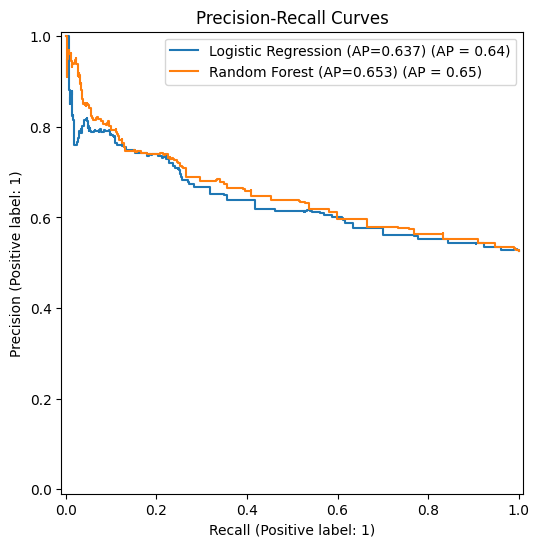

In [28]:
from sklearn.metrics import PrecisionRecallDisplay, average_precision_score
import matplotlib.pyplot as plt

# Get predictions from both models
y_pred_proba_lr = best_model_lr.predict_proba(X_test)[:, 1]
y_pred_proba_rf = best_model_rf.predict_proba(X_test)[:, 1]

# Calculate AP scores
ap_lr = average_precision_score(y_test, y_pred_proba_lr)
ap_rf = average_precision_score(y_test, y_pred_proba_rf)

# Create PR curves
fig, ax = plt.subplots(figsize=(10, 6))

PrecisionRecallDisplay.from_predictions(
    y_test, y_pred_proba_lr, 
    name=f'Logistic Regression (AP={ap_lr:.3f})',
    ax=ax
)

PrecisionRecallDisplay.from_predictions(
    y_test, y_pred_proba_rf, 
    name=f'Random Forest (AP={ap_rf:.3f})',
    ax=ax
)

ax.set_title('Precision-Recall Curves')
ax.legend()
plt.show()

Based on the precision recall curves, the Random Forest classifier performs slightly better, so I will choose to go with the random Forest classifier as my main model.

In [29]:
best_model = best_model_rf

proba_oof = cross_val_predict(
    best_model, X_train, y_train,
    cv=cv_rf, method="predict_proba", n_jobs=-1
)

# Fit once so we can read class ordering safely
best_model.fit(X_train, y_train)
classes = best_model.named_steps["randomforestclassifier"].classes_
pos_label = 1
pos_idx = list(classes).index(pos_label)

pred_oof = proba_oof[:, pos_idx]
print("classes:", classes, "| pos_idx:", pos_idx)

# Quick distribution sanity check (optional but VERY helpful)
print("OOF prob min/25/50/75/max:",
      float(np.min(pred_oof)),
      float(np.quantile(pred_oof, 0.25)),
      float(np.quantile(pred_oof, 0.50)),
      float(np.quantile(pred_oof, 0.75)),
      float(np.max(pred_oof)))

classes: [0 1] | pos_idx: 1
OOF prob min/25/50/75/max: 0.030846281803876198 0.45661749377949684 0.5037098241692664 0.5716624506049476 1.0


In [30]:
prec, rec, thr = precision_recall_curve(y_train, pred_oof)
f1 = 2*prec*rec/(prec+rec + 1e-9)

best_i = int(np.nanargmax(f1[:-1]))  # thr aligns with f1[:-1]
thr_high = float(thr[best_i])
binary_threshold = thr_high
print("thr_high (best F1 on OOF):", thr_high)
print("best F1:", float(f1[best_i]))

thr_high (best F1 on OOF): 0.3354183042802519
best F1: 0.6935233082820994


## Precision Recall Curve plot

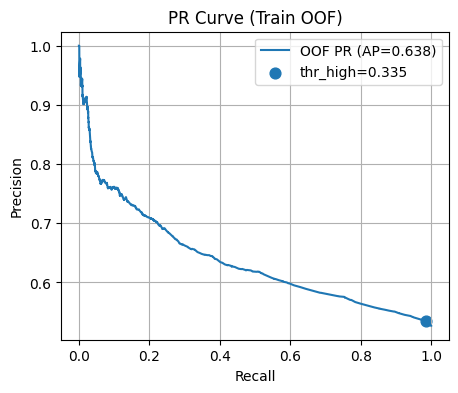

In [31]:
ap = average_precision_score(y_train, pred_oof)
plt.figure(figsize=(5,4))
plt.plot(rec, prec, label=f"OOF PR (AP={ap:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("PR Curve (Train OOF)")
plt.grid(True)

# Mark the chosen threshold point on the curve
plt.scatter(rec[best_i], prec[best_i], s=60, label=f"thr_high={thr_high:.3f}")
plt.legend()
plt.show()

In [32]:
low_target = 0.60   # 60% low risk
high_target = 0.20  # 20% high risk (top 20%)
# medium is the remaining 20%

thr_low  = float(np.quantile(pred_oof, low_target))
thr_high = float(np.quantile(pred_oof, 1 - high_target))

print("Band thresholds (quantiles): thr_low=", thr_low, "thr_high=", thr_high)

low_share  = float(np.mean(pred_oof < thr_low))
med_share  = float(np.mean((pred_oof >= thr_low) & (pred_oof < thr_high)))
high_share = float(np.mean(pred_oof >= thr_high))
print(f"Shares → low: {low_share:.3f}, medium: {med_share:.3f}, high: {high_share:.3f}")

Band thresholds (quantiles): thr_low= 0.5391687381469901 thr_high= 0.5801035310835776
Shares → low: 0.598, medium: 0.202, high: 0.201


In [33]:
p_test = best_model.predict_proba(X_test)[:, pos_idx]

test_ap   = float(average_precision_score(y_test, p_test))
test_prec = float(precision_score(y_test, p_test >= thr_high, zero_division=0))
test_rec  = float(recall_score(y_test,  p_test >= thr_high, zero_division=0))
test_f1   = float(f1_score(y_test,      p_test >= thr_high, zero_division=0))

print("Test AP:", test_ap)
print("Test Precision at thr_high:", test_prec)
print("Test Recall atthr_high:", test_rec)
print("Test F1 at thr_high:", test_f1)

Test AP: 0.6534849547066757
Test Precision at thr_high: 0.717032967032967
Test Recall atthr_high: 0.251566265060241
Test F1 at thr_high: 0.3724580806278987


## Save artifacts to model_store/baseline_v1 and evals/

In [34]:
MODEL_TAG = "baseline_v1" 

ROOT = Path("Course-Load-Risk")
MODEL_DIR = ROOT/"backend"/"model_store"/MODEL_TAG
EVALS_DIR = ROOT/"evals"

MODEL_DIR.mkdir(parents=True, exist_ok=True)
EVALS_DIR.mkdir(parents=True, exist_ok=True)

joblib.dump(best_model, MODEL_DIR/"model.joblib")

(MODEL_DIR/"feature_names.json").write_text(json.dumps(FEATURES, indent=2))

pd.DataFrame([{
    "model_tag": MODEL_TAG,
    "test_avg_precision": float(test_ap),
    "test_precision_at_thr": float(test_prec),
    "test_recall_at_thr": float(test_rec),
    "test_f1_at_thr": float(test_f1),
    "threshold": [ float(thr_high), float(thr_low)],
    "n_test": int(len(y_test)),
}]).to_csv(EVALS_DIR/f"eval_{MODEL_TAG}.csv", index=False)

meta = {
    "model_tag": MODEL_TAG,
    "trained_at": dt.datetime.utcnow().isoformat()+"Z",
    "algo": type(best_model.named_steps[list(best_model.named_steps.keys())[-1]]).__name__,
    "decision_threshold": float(binary_threshold),   # binary cutoff
    "thresholds": {                              # UI bands
        "low": float(thr_low),
        "high": float(thr_high),
    },
    "threshold_policy": "bands=quantiles" ,  # or "bands=buffer_around_decision"
    "features_count": len(FEATURES),
    "sklearn_version": __import__("sklearn").__version__,
}

(MODEL_DIR/"meta.json").write_text(json.dumps(meta, indent=2), encoding="utf-8")

print("Saved artifacts to:", MODEL_DIR)
print("Saved eval CSV to  :", EVALS_DIR/f"eval_{MODEL_TAG}.csv")

Saved artifacts to: Course-Load-Risk/backend/model_store/baseline_v1
Saved eval CSV to  : Course-Load-Risk/evals/eval_baseline_v1.csv


/var/folders/z4/4803pm_d5gs3wzcdfkb6f1cw0000gn/T/ipykernel_94727/1257677497.py:26: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "trained_at": dt.datetime.utcnow().isoformat()+"Z",


## Summary/Conclusion
The binary threshold found from the precision recall curve sits at around 0.35. Now when adding a new class (medium risk), we find that the low threshold is at around 0.335, which is a very small range for medium risk data to fit in. This means that this area is quite dense and is producing such thresholding due to the distribution. So I added quantile risk bands to guarantee that the medium risk class exists and will be predicted. 

To summarize my approach, I trained 2 models, a logistic regression model and random forest classifier, hyperparameter tuned both models, and decided to go with the forest classifier due to it having a slightly higher performance based on Average precision scores and the precision recall curve.